# Week 9: Huge images

Today, we will go through an alternative training process which has use for experimental 3D image data where we only have one (or very few) unlablled image.
The training process is more or less identical to the procedure from this paper:

**3D virtual histopathology of cardiac tissue from Covid-19 patients based on phase- contrast X- ray tomography**<br/>
Marius Reichardt, Patrick Møller Jensen, Vedrana Andersen Dahl, Anders Bjorholm Dahl, Maximilian Ackermann, Harshit Shah, Florian Länger, Christopher Werlein, Mark P Kuehnel, Danny Jonigk, Tim Salditt<br/>
eLife, 2021<br/>
https://elifesciences.org/articles/71359.pdf

First, let's import the necessary libraries:

In [3]:
from os.path import join
from time import perf_counter as time

import matplotlib.pyplot as plt
import monai
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.networks.utils import one_hot
import numpy as np
from skimage.measure import label as skimage_label, regionprops
import torch
from tqdm import tqdm

Next, we'll load the 3D image. To avoid you having to add labels we'll also load the labels used for the above mentioned paper.

In [2]:
DATA_PATH='./data/CovidHeart/covid_small'
image = torch.from_numpy(np.load(join(DATA_PATH, 'train', 'data_0.npy'))).float()
train_label = torch.from_numpy(np.load(join(DATA_PATH, 'train', 'mask_0.npy')))
val_label = torch.from_numpy(np.load(join(DATA_PATH, 'val', 'mask_0.npy')))

FileNotFoundError: [Errno 2] No such file or directory: '/dtu/3d-imaging-center/courses/02510/data/CovidHeart/covid_small\\train\\data_0.npy'

Let's visualize a slice of the image and the corresponding labels. Note that the labels have been max projected over the z-axis.

Text(0.5, 1.0, 'val_label')

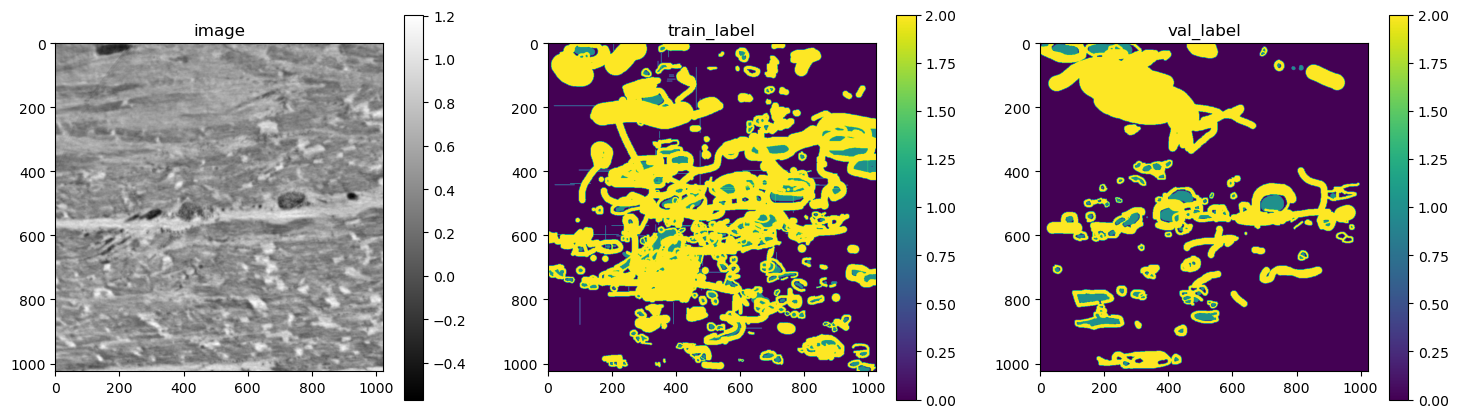

In [ ]:
# subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
im = ax[0].imshow(image[:, :, image.shape[2] // 2], cmap='gray')
fig.colorbar(im, ax=ax[0])
ax[0].set_title('image')
im = ax[1].imshow(train_label.max(dim=2).values)
fig.colorbar(im, ax=ax[1])
ax[1].set_title('train_label')
im = ax[2].imshow(val_label.max(dim=2).values)
fig.colorbar(im, ax=ax[2])
ax[2].set_title('val_label')

Notice that only part of the volume has been labelled (about 0.14 % of the voxels). The label image has the following values: 
* 0 to indicates that the pixel is unlabeled.
* 1 to indicate blood vessels.
* 2 to indicate background tissue.

In this exercise, we will use the labels to train a U-Net model to segment the blood vessels in the image. We will use the labels to train the model, and then use the model to predict the labels for the unlabeled voxels.

To deal with the large image size, we will train on random crops of the image. We use the `RandCropByPoseNegLabeld` from MONAI to achieve this:

In [ ]:
PATCH_SIZE=(96,) * 3         # Size of crops
PROB_FOREGROUND_CENTER=0.95  # Probability that center of crop is a labeled foreground voxel (ensures the crops often contain a label)

from monai.transforms import (
    Compose,
    CopyItemsd,
    EnsureChannelFirstd,
    FgBgToIndicesd,
    LabelToMaskd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    RandAxisFlipd,
)

train_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label'], channel_dim='no_channel'),
    CopyItemsd(keys=['label'], times=1, names=['mask']),                                                  # Copy label to new image mask
    LabelToMaskd(keys=['mask'], select_labels=[1, 2], merge_channels=True),                               # Convert mask to binary mask showing where labels are
    FgBgToIndicesd(keys=['mask'], fg_postfix='_fg_indices', bg_postfix='_bg_indices'),                    # Precompute indices of labelled voxels
    RandCropByPosNegLabeld(keys=['image', 'label', 'mask'], label_key='label', spatial_size=PATCH_SIZE,   # Extract random crop
                            pos=PROB_FOREGROUND_CENTER, neg=(1.0 - PROB_FOREGROUND_CENTER),
                            num_samples=1, fg_indices_key='mask_fg_indices', bg_indices_key='mask_bg_indices'),
    RandRotate90d(keys=['image', 'label', 'mask'], prob=0.5, spatial_axes=(0, 1)),                        # Randomly rotate
    RandRotate90d(keys=['image', 'label', 'mask'], prob=0.5, spatial_axes=(1, 2)),                        # Randomly rotate
    RandRotate90d(keys=['image', 'label', 'mask'], prob=0.5, spatial_axes=(0, 2)),                        # Randomly rotate
    RandAxisFlipd(keys=['image', 'label', 'mask'], prob=0.1),                                             # Randomly flip
])

These transforms will take a big image and it's labels and spit out a random crop of the image along with the corresponding labels and a mask indicating which voxels are unlabeled. With probability `PROB_FOREGROUND_CENTER`, the center of the crop will be labelled. This is to ensure that the model is trained on labelled voxels.

From there, we can add more transforms.
> ----
> **Task:** Add additional data augmentations. Please *don't* add intensity normalization as we'll use a pre-trained model later.
>
> ---
> **Solution:** See cell above. I added random 90 degree rotation around each and random axis flips. Quite simple, but it gets the job done.
>
> ---

Since our way of training is a bit different from normal, we will need to adapt MONAI's modules a bit.

Normally, we have a dataset of many images, and our batch (of size `B`) would be a random crop from `B` random images in the training dataset. An epoch then corresponds to going through the entire dataset once.

Here, we have a dataset of a single image, and our batch (of size `B`) will be `B` random crops from the same image. Of course, this means it doesn't make sense to talk about an epoch as we only have this one image. Instead, we simply pick how many batches we want to train for, before we do a validation run.

To make this work with PyTorch's `DataLoader` over many workers, we need a new dataset class that just returns the same image `B` * `num_batches` times. We could also just copy the image `B` * `num_batches` times, but that would be a waste of memory.

In [ ]:
class RepeatedCacheDataset(monai.data.CacheDataset):
    """
    CacheDataset that repeats the data.
    """

    def __init__(self, *args, num_repeats: int = 1, **kwargs):
        """
        Args:
            *args: Arguments to pass to CacheDataset.
            num_repeats (int): Number of times to repeat the data.
            **kwargs: Keyword arguments to pass to CacheDataset.
        """
        super().__init__(*args, **kwargs)
        self.num_repeats = num_repeats


    def __len__(self):
        """Returns number of items in the dataset."""
        return super().__len__() * self.num_repeats


    def __getitem__(self, index):
        """Returns the item at the given index."""
        index = index % super().__len__()
        return super().__getitem__(index)

We can now use this to define our dataset. ***Note*** this cell will take a little to run as it is precomputing the indices for the random crops.

In [ ]:
TRAIN_BATCH_SIZE=16
BATCHES_PER_EPOCHS=150

train_dataset = RepeatedCacheDataset(
    data=[{ 'image': image, 'label': train_label }],
    num_repeats=BATCHES_PER_EPOCHS * TRAIN_BATCH_SIZE,
    transform=train_transforms,
    num_workers=8,
    cache_rate=1.0,
    copy_cache=False  # Important to avoid slowdowns
)

Loading dataset: 100%|████████████████████████████| 1/1 [00:40<00:00, 40.34s/it]


We can now pop this dataset into a normal PyTorch `DataLoader` and it will work as expected:

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,  # No need to shuffle since we repeat the data
    num_workers=0,  # Just use the main thread for now, we just need it for visualization
)

Let's visualize a batch of random crops from the image and the corresponding labels:

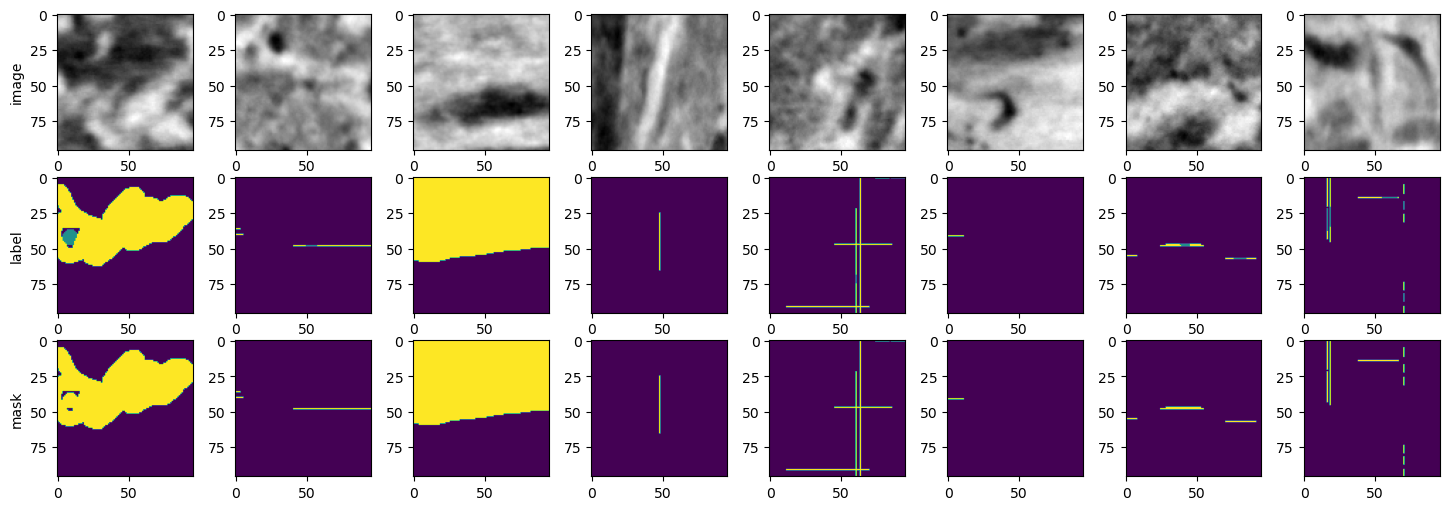

In [ ]:
batch = next(iter(train_loader))  # Get first batch

fig, ax = plt.subplots(3, 8, figsize=(18, 6))
for i in range(8):
    ax[0, i].imshow(batch['image'][i, 0, :, :, batch['image'].shape[3] // 2], cmap='gray')
    ax[1, i].imshow(batch['label'][i, 0, :, :, batch['label'].shape[3] // 2])
    ax[2, i].imshow(batch['mask'][i, 0, :, :, batch['mask'].shape[3] // 2])

    if i == 0:
        ax[0, i].set_ylabel('image')
        ax[1, i].set_ylabel('label')
        ax[2, i].set_ylabel('mask')

Notice that we produce both labels *and* a mask. The mask is used to ignore the unlabeled pixels when computing the loss.

Now, we need to define our validation data. Since we want the results to be comparable between runs, we cannot use random crops. Instead, we pre-extract all patches that cover a labeled region of the image. We can then use these patches to validate the model. We do this with the following function:

In [ ]:
from typing import Tuple, List, Dict

def extract_label_patches(
    image: np.ndarray,
    label: np.ndarray,
    patch_size: Tuple[int, int, int],
) -> List[Dict[str, np.ndarray]]:
    """
    Extract patches from image where label is non-zero.

    For each connected component in label, extract the bounding box.
    Split the bounding box into overlapping patches of size patch_size.
    Extract the patches from image and label.
    Return the patches as a list of { 'image': ..., 'label': ... } dicts.

    Args:
        image (np.ndarray): Image to extract patches from.
        label (np.ndarray): Label to extract patches from.
        patch_size (tuple): Size of the patches to extract.

    Returns:
        list: List of patches as { 'image': ..., 'label': ..., 'mask': ... } dicts.
    """
    props = regionprops(skimage_label(label > 0))  # Extract connected components of labeled voxels
    patches = []
    for pp in props:
        # Extract bounding box for connected component
        cc_min = pp.bbox[:3]
        cc_max = pp.bbox[3:]

        # Extract patches covering the bounding box
        for z in range(cc_min[0] - patch_size[0] // 2, cc_max[0] + patch_size[0] // 2, patch_size[0] // 2):
            for y in range(cc_min[1] - patch_size[1] // 2, cc_max[1] + patch_size[1] // 2, patch_size[1] // 2):
                for x in range(cc_min[2] - patch_size[2] // 2, cc_max[2] + patch_size[2] // 2, patch_size[2] // 2):
                    # Ensure patch is within image bounds
                    z_begin = max(z, 0)
                    y_begin = max(y, 0)
                    x_begin = max(x, 0)
                    z_end = min(z + patch_size[0], image.shape[0])
                    y_end = min(y + patch_size[1], image.shape[1])
                    x_end = min(x + patch_size[2], image.shape[2])

                    patch_label = label[z_begin:z_end, y_begin:y_end, x_begin:x_end]
                    if not patch_label.any():
                        # Skip empty patches
                        continue
                    patch_image = image[z_begin:z_end, y_begin:y_end, x_begin:x_end]

                    if patch_image.shape != patch_size:
                        # Pad patch if it is smaller than patch_size
                        pad_size = [(0, 0)] * 3
                        for d in range(3):
                            pad_size[d] = (0, patch_size[d] - patch_image.shape[d])
                        patch_image = np.pad(patch_image, pad_size, 'constant', constant_values=0)
                        pad_size = [(0, 0)] * 3
                        for d in range(3):
                            pad_size[d] = (0, patch_size[d] - patch_label.shape[d])
                        patch_label = np.pad(patch_label, pad_size, 'constant', constant_values=0)

                    patches.append({ 'image': patch_image, 'label': patch_label, 'mask': patch_label > 0 })

    return patches

We can now use this to define our validation dataset:

In [ ]:
VAL_BATCH_SIZE=16

val_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label', 'mask'], channel_dim='no_channel'),
])
val_dataset = CacheDataset(
    data=extract_label_patches(image, val_label, PATCH_SIZE),
    transform=val_transforms,
    num_workers=8,
    cache_rate=1.0
)

Loading dataset: 100%|█████████████████████| 2204/2204 [00:04<00:00, 499.46it/s]


And we can now stick it into a normal PyTorch `DataLoader`:

In [ ]:
val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Just use the main thread for now, we just need it for visualization
)

Let's visualize a batch of validation crops from the image and the corresponding labels:

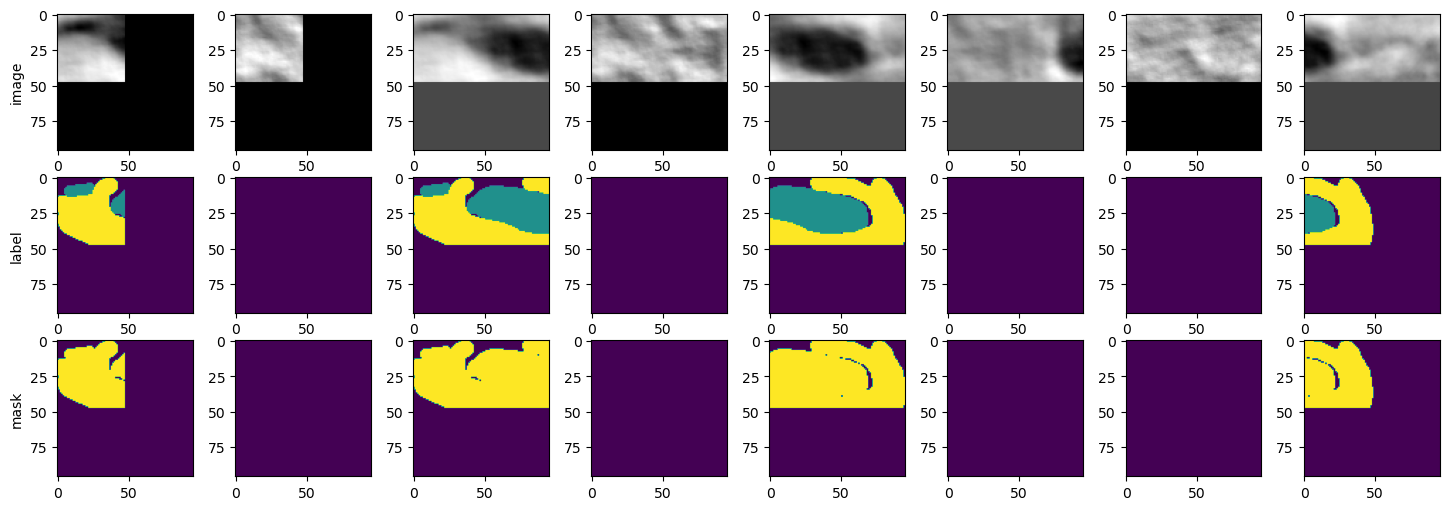

In [ ]:
batch = next(iter(val_loader))  # Get first batch

fig, ax = plt.subplots(3, 8, figsize=(18, 6))
for i in range(8):
    ax[0, i].imshow(batch['image'][i, 0, :, :, batch['image'].shape[3] // 2], cmap='gray')
    ax[1, i].imshow(batch['label'][i, 0, :, :, batch['label'].shape[3] // 2])
    ax[2, i].imshow(batch['mask'][i, 0, :, :, batch['mask'].shape[3] // 2])

    if i == 0:
        ax[0, i].set_ylabel('image')
        ax[1, i].set_ylabel('label')
        ax[2, i].set_ylabel('mask')

Notice how the crops are like a sliding window over the labelled region.

Let's now define a U-Net model to use. ***Note*** please don't change the model architecture, as you will load a pretrained model.

In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2,  # Read about dropout here: https://www.deeplearningbook.org/contents/regularization.html#pf20
)

We'll now load a pretrained model. Training a model from scratch would take a long time, and we want to focus on the data loading and training loop.



In [ ]:
checkpoint = torch.load('/dtu/3d-imaging-center/courses/02510/exercises/Week09/worst_model_checkpoint.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

We now add the loss function and optimizer. This will be as usual. We will use the masked dice loss to deal with unlabelled voxels.

> ---
> **Task:** Add the optimizer and set the learning rate. If you want to use AMP (automatic mixed precision), you should also add a scaler.
>
> *Hint:* View the exercises from previous weeks for examples.
> 
> ---
> **Solution:** See cell below. I used Adam with a learning rate of 1e-4. I also added a gradient scaler to use AMP.
>
> ---

In [ ]:
LR = 1e-4

loss_fn = monai.losses.MaskedDiceLoss(include_background=True)
### YOUR CODE HERE ###
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler()

We now set up the training loop. Below is skeleton code which loops over the training and validation batches. You need to fill in the missing parts. 

> ---
> **Task:** Fill in the missing parts of the training loop. Specifically, you need to:
>  * Do the forward pass.
>  * Compute the loss.
>  * Do the backward pass.
>  * Step the optimizer.
>  * Add printing/logging to monitor progress.
>  * If you want to use AMP, add code for that. 
>
> ---
> **Solution:** See cell below. I added the missing parts of the training loop. I also added some printing to monitor progress. I also added code to use AMP.
>
> *Note the folowing*: 
>  * I call `.softmax(dim=1)` on the model output to get a probability map. This is because the Dice loss function expects a probability map, and not a logit map. If you don't do this, you will get weird losses.
>  * I pass both the prediction, the labels and the mask to the loss function. This is because the loss function needs to know which voxels are labeled.
>
> ---

In [ ]:
NUM_EPOCHS = 5

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,  # Don't shuffle since we use random crops
    ### YOUR CODE HERE ###
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    ### YOUR CODE HERE ###
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)

model.cuda()

print('Starting training')
all_train_losses = []
all_val_losses = []
best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    mean_train_loss = 0
    num_samples = 0
    step = 0
    t0 = time()
    model.train()
    for batch in tqdm(train_loader):
        image_b = batch['image'].as_tensor().cuda(non_blocking=True)
        label = batch['label'].as_tensor().cuda(non_blocking=True)
        mask = batch['mask'].as_tensor().cuda(non_blocking=True)
        label = one_hot(label, num_classes=3)
        label = label[:, 1:]

        ### YOUR CODE HERE ###
        with torch.cuda.amp.autocast():
            pred = model(image_b)
            loss = loss_fn(input=pred.softmax(dim=1), target=label, mask=mask)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=None)

        mean_train_loss += loss.detach() * len(image_b)
        num_samples += len(image_b)
        step += 1

    train_time = time() - t0
    mean_train_loss = mean_train_loss / num_samples
    all_train_losses.append(mean_train_loss.item())

    mean_val_loss = 0
    num_samples = 0
    step = 0
    t0 = time()
    model.eval()
    for batch in tqdm(val_loader):
        image_b = batch['image'].as_tensor().cuda(non_blocking=True)
        label = batch['label'].as_tensor().cuda(non_blocking=True)
        mask = batch['mask'].as_tensor().cuda(non_blocking=True)

        with torch.no_grad():
            label = one_hot(label, num_classes=3)
            label = label[:, 1:]

            ### YOUR CODE HERE ###
            with torch.cuda.amp.autocast():
                pred = model(image_b)
                loss = loss_fn(input=pred.softmax(dim=1), target=label, mask=mask)

        mean_val_loss += loss * len(image_b)
        num_samples += len(image_b)
        step += 1

    val_time = time() - t0
    mean_val_loss = mean_val_loss / num_samples
    all_val_losses.append(mean_val_loss.item())
    if mean_val_loss.item() < best_val_loss:
        print('Saving best model checkpoint, epoch', epoch, 'val loss', mean_val_loss.item())
        best_val_loss = mean_val_loss
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict(),
            'epoch': epoch,
            'train_losses': all_train_losses,
            'val_losses': all_val_losses,
        }, 'model_checkpoint.pth')

    print('Epoch', epoch + 1, 'train loss', mean_train_loss.item(), 'val loss', mean_val_loss.item(), 'train time', train_time, 'seconds val time', val_time, 'seconds')

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 6.19 MiB is free. Process 30204 has 1.09 GiB memory in use. Process 29600 has 11.09 GiB memory in use. Process 1063 has 2.71 GiB memory in use. Including non-PyTorch memory, this process has 892.00 MiB memory in use. Of the allocated memory 573.01 MiB is allocated by PyTorch, and 12.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

If you added code to save the best model during training, then reload it now. Otherwise, just use the final model.

> ---
> **Task (optional):** Load the best model if you saved one during training.
>
> ---
> **Solution:** See cell below. I used `torch.load` to load the model.
>
> ---

In [ ]:
### YOUR CODE HERE ###
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model'])

Having trained a model, we can now use it to predict the labels for the unlabeled voxels. We do this by sliding a window over the image and predicting the labels for each window. Then, we combine the predictions to get a full image prediction.

Luckily, MONAI has a function to do this for us: `sliding_window_inference`.

In [ ]:
from monai.inferers import sliding_window_inference

INFERENCE_BATCH_SIZE = 16
WINDOW_OVERLAP = 0.5

model.eval()
with torch.no_grad():
    # Evaluate the model on the image using MONAI sliding window inference
    pred = sliding_window_inference(
        image[None, None],
        PATCH_SIZE,
        INFERENCE_BATCH_SIZE,
        lambda x: model(x.cuda()).softmax(dim=1).cpu(),  # send patch to GPU, run model, call softmax, send result back to CPU
        overlap=WINDOW_OVERLAP,
        mode='gaussian',
        progress=True,
    )
pred = pred.numpy()

Let's visualize the predictions as three cross sections through the image:

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(image[:, :, image.shape[-1] // 2], cmap='gray')
ax[0].imshow(pred[0, 0, :, :, pred.shape[-1] // 2], alpha=0.4)
ax[1].imshow(image[:, image.shape[-2] // 2, :], cmap='gray')
ax[1].imshow(pred[0, 0, :, pred.shape[-2] // 2, :], alpha=0.4)
ax[2].imshow(image[image.shape[-3] // 2, :, :], cmap='gray')
ax[2].imshow(pred[0, 0, pred.shape[-3] // 2, :, :], alpha=0.4)
plt.show()

Seems pretty okay (hopefully)! The labelled regions seem to correspond to the blood vessels. The model is not perfect, but it is not too bad either.

To really get a sense of good the segmentation is, we need to view it in 3D. Let's save the prediction as a file.

> ---
> **Task:** Save the prediction as a file by running the cell below. Depending on what viewer you want, uncomment the appropriate line.
>
> ---
> **Solution:** See cell below. I uncommented the line for TomViz as that's my preferred viewer.
>
> ---

In [ ]:
pred = np.uint8(pred[0, 0] * 255)

from skimage.io import imsave
import nibabel as nib

# Pick one
#imsave('pred.tiff', pred)  # For paraview
nib.save(nib.Nifti1Image(pred, np.eye(4)), 'pred.nii.gz') # For ITK-SNAP
#np.save('pred.npy', pred)  # For TomViz

> ---
> **Task:** Open the file in your favourite 3D viewer. How does it look? Can you see the blood vessels? What do you notice in 3D that wasn't visible in the 2D views?
>
> ---
> **Solution:** I opened the results in TomViz. See below
> 
> 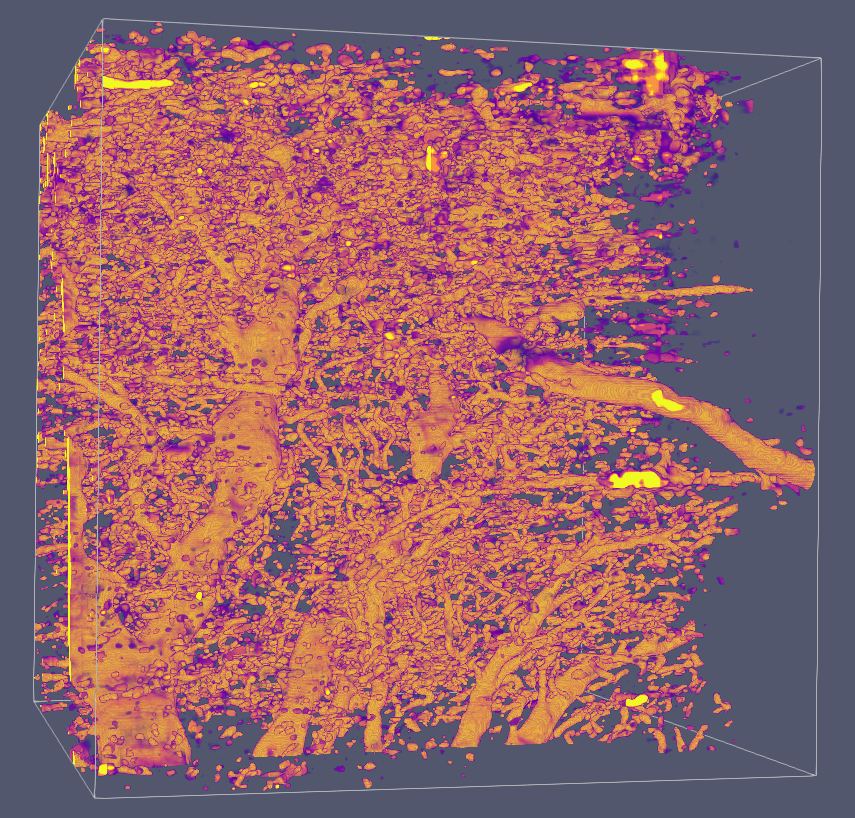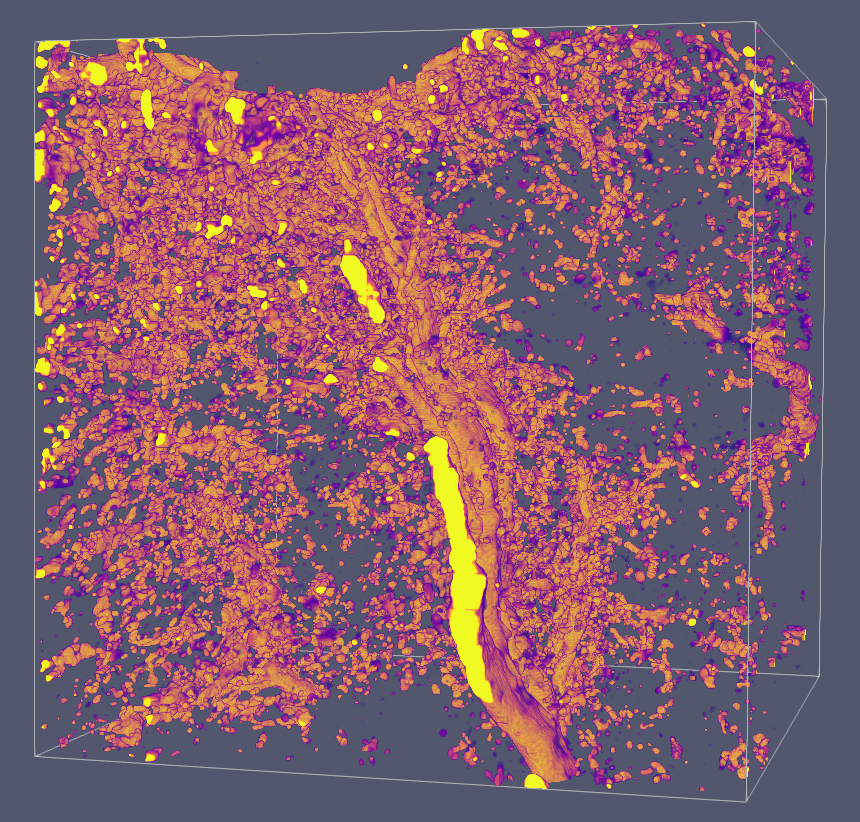
>
> Doesn't look horrible! You can definitely see the blood vessels going through the volume. In 3D, you can also see that there's a lot of noise in the form of false positives. This was hard to spot in the 2D views, since it's hard to spot if something is a long tube or just a small blob when you only see a single slice.
> 
> ---